In [1]:
import pathlib

import tensorflow as tf

root_path = './images' 
data_root = pathlib.Path(root_path)
for item in data_root.iterdir():
    print(item)
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count
all_image_paths[:10]

images\simon
images\simon_wo_glasses


['images\\simon\\simon_8.jpg',
 'images\\simon_wo_glasses\\simon_33.jpg',
 'images\\simon\\simon_3.jpg',
 'images\\simon_wo_glasses\\simon_30.jpg',
 'images\\simon\\simon_15.jpg',
 'images\\simon\\simon_14.jpg',
 'images\\simon\\simon_25.jpg',
 'images\\simon\\simon_5.jpg',
 'images\\simon\\simon_23.jpg',
 'images\\simon\\simon_12.jpg']

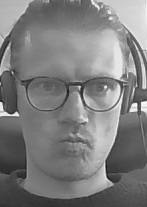

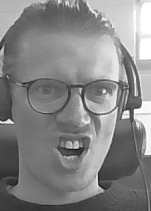

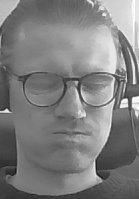

In [2]:
import IPython.display as display

#def caption_image(image_path):
#    image_rel = pathlib.Path(image_path).relative_to(data_root)
#    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    #print(caption_image(image_path))
    print()

In [3]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['simon', 'simon_wo_glasses']

In [4]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'simon': 0, 'simon_wo_glasses': 1}

In [5]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]


In [6]:
img_path = all_image_paths[0]
img_path

'images\\simon\\simon_8.jpg'

In [7]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [8]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(195, 135, 1)
<dtype: 'uint8'>


In [9]:
img_final = tf.image.resize(img_tensor, [96, 96])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(96, 96, 1)
0.16009976
1.0


In [14]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

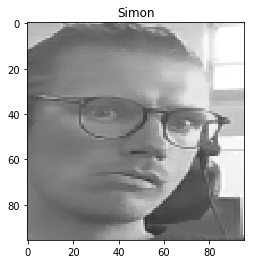

In [15]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [16]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [17]:
#print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

AttributeError: 'TensorSliceDataset' object has no attribute 'output_types'

In [18]:
image_ds = path_ds.map(load_and_preprocess_image)

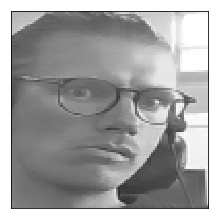

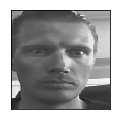

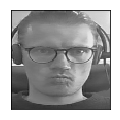

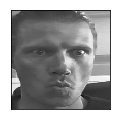

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

In [20]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [21]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

simon
simon_wo_glasses
simon
simon_wo_glasses
simon
simon
simon
simon
simon
simon


In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [23]:
print(image_label_ds)

<ZipDataset shapes: ((96, 96, 3), ()), types: (tf.float32, tf.int64)>


In [24]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((96, 96, 3), ()), types: (tf.float32, tf.int32)>

In [25]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.float32, tf.int32)>

In [27]:
mobile_net=0
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), include_top=False)
mobile_net.trainable=False

In [28]:
help(keras_applications.mobilenet_v2.preprocess_input)

NameError: name 'keras_applications' is not defined

In [29]:
def change_range(image,label):
      return 2*image-1, label

keras_ds = ds.map(change_range)

In [30]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [31]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 3, 3, 1280)


In [32]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [33]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.0423894
max logit: 2.6013834

Shape: (32, 2)


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [35]:
len(model.trainable_variables)

2

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
import numpy as np
steps_per_epoch=np.ceil(len(all_image_paths)/BATCH_SIZE)

In [38]:
model.fit(ds, epochs=10, steps_per_epoch=3)

Epoch 1/100
3/3 [==============================] - 4s 1s/step - loss: 2.3786 - accuracy: 0.4688
Epoch 2/100
3/3 [==============================] - 2s 554ms/step - loss: 0.6643 - accuracy: 0.5104
Epoch 3/100
3/3 [==============================] - 2s 550ms/step - loss: 0.6787 - accuracy: 0.6042
Epoch 4/100
3/3 [==============================] - 2s 549ms/step - loss: 0.6787 - accuracy: 0.4792
Epoch 5/100
3/3 [==============================] - 2s 549ms/step - loss: 0.6787 - accuracy: 0.5312
Epoch 6/100
3/3 [==============================] - 2s 563ms/step - loss: 0.6931 - accuracy: 0.6146
Epoch 7/100
3/3 [==============================] - 2s 567ms/step - loss: 0.6859 - accuracy: 0.6042
Epoch 8/100
3/3 [==============================] - 2s 550ms/step - loss: 0.6931 - accuracy: 0.6146
Epoch 9/100
3/3 [==============================] - 2s 551ms/step - loss: 0.6931 - accuracy: 0.5625
Epoch 10/100
3/3 [==============================] - 2s 550ms/step - loss: 0.6931 - accuracy: 0.6042
Epoch 11/100

3/3 [==============================] - 2s 564ms/step - loss: 0.6931 - accuracy: 0.6042
Epoch 84/100
3/3 [==============================] - 2s 628ms/step - loss: 0.6931 - accuracy: 0.6042
Epoch 85/100
3/3 [==============================] - 2s 665ms/step - loss: 0.6931 - accuracy: 0.5521
Epoch 86/100
3/3 [==============================] - 2s 597ms/step - loss: 0.6931 - accuracy: 0.5729
Epoch 87/100
3/3 [==============================] - 2s 616ms/step - loss: 0.6931 - accuracy: 0.5833
Epoch 88/100
3/3 [==============================] - 2s 563ms/step - loss: 0.6931 - accuracy: 0.5417
Epoch 89/100
3/3 [==============================] - 2s 655ms/step - loss: 0.6931 - accuracy: 0.6354
Epoch 90/100
3/3 [==============================] - 2s 584ms/step - loss: 0.6931 - accuracy: 0.5625
Epoch 91/100
3/3 [==============================] - 2s 565ms/step - loss: 0.6931 - accuracy: 0.5833
Epoch 92/100
3/3 [==============================] - 2s 551ms/step - loss: 0.6931 - accuracy: 0.5833
Epoch 93/100


In [ ]:

output = model.predict_classes(ds)#, verbose=1)
#conf_mat = confusion_matrix(y_test.flatten(), output)
#plt.table(cellText=conf_mat,
                      #rowLabels=rows,
                      #rowColours=colors,
                      #colLabels=columns,
#                      loc='center')
#plt.axis('off')

In [ ]:
ds.list_files

In [ ]:
ds.